# Spirtes-Glymour-Scheines (SGS) Algorithm

The Spirtes-Glymour-Scheines (SGS) is a constraint-based algorithm for causal discovery that uses conditional independence tests to determine the presence of causal relationships between variables. The algorithm is based on the following assumptions: 

1. The causal relationships between variables form a directed acyclic graph (DAG).
2. The variables are generated by a linear Gaussian model.
3. The conditional independence tests are reliable.

The algorithm proceeds in three main stages:

```pseudo
# Skeleton Phase
1. Start with a complete undirected graph on the set of all variables
2. For each pair of variables X and Y in the graph do the following:
    2.1. If X and Y are conditionally independent given some subset of the remaining variables, then remove the edge between X and Y
    
# V-Structure Phase
3. For each pair of non-adjacent variables X and Y, do the following:
    3.1. If there exists a variable Z such the both X -> Z and Y -> Z exist in the graph, add a directed edge X -> Y if there is no subset of remaining variables that X is conditionally independent of Y.

# Orientation Phase
4. While there exists directed edges that can be oriented do the following:
    4.1. For each pair of variables X, Y where X - Y is an edge in the graph and Y - Z is a directed edge for some variable Z, orient X -Y as X -> Y if not orienting it in that way would create a new v-structure that is not justified by the data.
    4.2. For each pair of variables X, Y where X - Y is an edge in the graph and X - Z is a directed edge for some variable Z, orient X - Y as X -> Y if not orienting it in that way would create a cycle.
```

## Implementation

In [55]:
import pandas as pd
import numpy as np
import networkx as nx

import pingouin as pg

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

from scipy.stats import pearsonr


import os
import math
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


In [108]:
def test_independence(data : pd.DataFrame, X : str, Y : str, verbose=False):
    
    # Compute the Pearson correlation coefficient and the p-value
    corr, p_value = np.round(pearsonr(data[X], data[Y]), 4)
    
    [print(f"({X} \ind {Y}) = {corr}" ) if verbose else None]
    
    # If the p-value is larger than 0.05, 
    # we accept the null hypothesis of independence
    return p_value > 0.05

# initialize z as a list type
def test_conditional_independence(data : pd.DataFrame, X : str, Y : str, Z,  verbose=False):

    # Compute the partial correlation of x and y given  Z
    partial_corr = pg.partial_corr(data=data, x=X, y=Y, covar=Z)
    
    [print(f"({X} \ind {Y}) | {Z} = {partial_corr}" ) if verbose else None]

    # If the p-value is larger than 0.05, we accept the null hypothesis of independence
    return partial_corr['p-val'].values[0] > 0.05

def skeleton_phase( graph : nx.classes.graph.Graph, data : pd.DataFrame, verbose=False ):

    #For each pair of variables X and Y in the graph
    for node1 in graph.nodes:
        for node2 in graph.nodes:
            
            if node1 == node2:
                continue

            # Check for conditional independence
            # If X and Y are conditionally independent given some subset of the remaining variables, 
            # then remove the edge between X and Y
            
            independent = test_independence(data, node1, node2, verbose)
            [print(f"\tPr({node1} || {node2}) : {independent}") if independent and verbose else None]
            
            if independent:
                # If conditionally independent, remove the edge
                try:
                    graph.remove_edge(node1, node2)
                except nx.NetworkXError:
                    print("Edge already removed")
            [print("-----------------------------------------") if verbose else None]
                    
    return graph

def v_structure_phase( graph : nx.classes.graph.Graph, data : pd.DataFrame, verbose=False ):
    
    # Identify all triples (X, Y, Z) that form a V-structure i -> j <- k
    for X in graph.nodes():
        for Y in graph.nodes():
            for Z in graph.nodes():
                
                if X == Y or X == Z or Y == Z:
                    continue
                
                # If X -> Y and Z -> Y, then we found a V-Structure in the graph and we need to test for conditional independence
                if graph.has_edge(X, Y) and graph.has_edge(Z,Y) and not( graph.add_edge(X,Z) ):
                    
                    if not test_conditional_independence(data, X, Z, {Y}, verbose):
                        graph.remove_edge(X, Z)
                
                
                
                
                
                
                
                
            # If there exists a variable Z such the both X -> Z and Y -> Z exist in the graph, 
            # add a directed edge X -> Y if there is no subset of remaining variables that X is conditionally independent of Y.
            graph.neighbors
    
    
    
    
    return None



# Step 2: V-structure orientation
#    # Identify all triples (i, j, k) that form a V-structure i -> j <- k
#    for node1 in graph.nodes:
#        for node2 in graph.nodes:
#            for node3 in graph.nodes:
#                if node1 == node2 or node1 == node3 or node2 == node3:
#                    continue

#                # If node1 and node3 are not connected, but both are connected to node2
#                if not graph.has_edge(node1, node3) and graph.has_edge(node1, node2) and graph.has_edge(node2, node3):
                    # If node2 is not in the subset that renders node1 and node3 independent
                    # This is a placeholder - you need to implement the actual test depending on your data
#                    if not conditional_independence(data, node1, node3, {node2}):
#                        # Orient as a V-structure
#                        graph.remove_edge(node1, node2)
#                        graph.remove_edge(node2, node3)
#                        graph.add_edge(node1, node2, arrowhead='vee')
#                        graph.add_edge(node2, node3, arrowhead='vee')


def orientation_phase():
    
    return None

def sgs( data : pd.DataFrame, verbose=False ):
    
    # start with a complete undirected graph
    graph = nx.complete_graph( data.columns )
    
    # apply skeleton phase
    graph = skeleton_phase( graph, data, verbose )
    
    # apply v-structure phase
    # graph = v_structure_phase( graph, data, verbose )
    
    # apply orientation phase
    # graph = orientation_phase( graph, data, verbose )
    
    return graph
    

## The Model

Let's suppose that the groundtruth causal graph is the following:

In [109]:
cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
cbn

(pyAgrum.BayesNet<double>@0x7fe06bbb6a00) BN{nodes: 4, arcs: 2, domainSize: 16, dim: 7, mem: 112o}

In [110]:
data = pd.read_csv( "data/bn_data.csv" , sep='\t')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


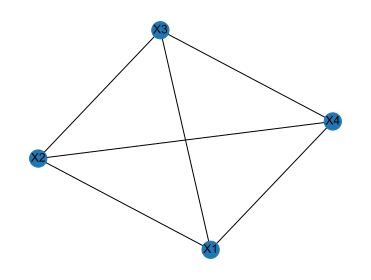

In [113]:
graph = nx.complete_graph( data.columns )

#visualize the initial graph
fig, ax = plt.subplots()
nx.draw(graph, with_labels=True, ax=ax)
plt.show()

In [117]:
nodes = graph.neighbors("X1")
for node in nodes:
    print(node)

X2
X3
X4


(X1 || X2) = -0.3859
-----------------------------------------
(X1 || X3) = 0.933
-----------------------------------------
(X1 || X4) = 0.0136
	Pr(X1 || X4) : True
-----------------------------------------
(X2 || X1) = -0.3859
-----------------------------------------
(X2 || X3) = -0.0333
	Pr(X2 || X3) : True
-----------------------------------------
(X2 || X4) = -0.0042
	Pr(X2 || X4) : True
-----------------------------------------
(X3 || X1) = 0.933
-----------------------------------------
(X3 || X2) = -0.0333
	Pr(X3 || X2) : True
Edge already removed
-----------------------------------------
(X3 || X4) = 0.0135
	Pr(X3 || X4) : True
-----------------------------------------
(X4 || X1) = 0.0136
	Pr(X4 || X1) : True
Edge already removed
-----------------------------------------
(X4 || X2) = -0.0042
	Pr(X4 || X2) : True
Edge already removed
-----------------------------------------
(X4 || X3) = 0.0135
	Pr(X4 || X3) : True
Edge already removed
-----------------------------------------


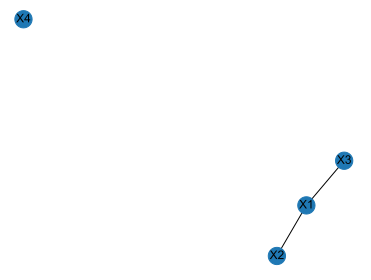

In [112]:
graph = sgs( data, verbose=True )

#visualize the graph
fig, ax = plt.subplots()
nx.draw(graph, with_labels=True, ax=ax)
plt.show()